# Класифікація Fashion MNIST з використанням VGG16

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


2025-08-10 09:37:24.623897: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 09:37:24.643584: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 09:37:24.778920: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 09:37:24.892946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754811444.981139   29817 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754811445.00

===========================
# 1. Завантаження та підготовка даних
===========================


In [2]:

# Завантаження даних Fashion MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Розділення валідаційної частини
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42
)

# Функція для перетворення grayscale -> RGB та ресайзу


def prepare_rgb_images(x):
    x = tf.expand_dims(x, -1)  # (n, 28, 28, 1)
    x = tf.image.resize(x, (48, 48))  # (n, 48, 48, 1)
    x = tf.image.grayscale_to_rgb(x)  # (n, 48, 48, 3)
    return x


x_train_rgb = prepare_rgb_images(x_train)
x_val_rgb = prepare_rgb_images(x_val)
x_test_rgb = prepare_rgb_images(x_test)

# Нормалізація через preprocess_input (від VGG16)
x_train_rgb = preprocess_input(x_train_rgb)
x_val_rgb = preprocess_input(x_val_rgb)
x_test_rgb = preprocess_input(x_test_rgb)

# One-hot кодування міток
y_train_cat = to_categorical(y_train, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test, 10)



2025-08-10 09:37:28.995948: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


===========================
# 2. Побудова tf.data.Dataset
===========================


In [3]:

batch_size = 64
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train_rgb, y_train_cat))
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(1)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((x_val_rgb, y_val_cat))
    .batch(batch_size)
    .prefetch(1)
)
test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test_rgb, y_test_cat))
    .batch(batch_size)
    .prefetch(1)
)


===========================
# 3. Побудова моделі (VGG16 + top)
===========================

In [4]:
# Базова модель VGG16 без верхнього класифікатора
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))
base_model.trainable = False  # заморозити шари VGG16

# Додаємо власні шари поверх
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(10, activation="softmax")(x)  # 10 класів для прикладу


# Створюємо модель
model = models.Model(inputs=base_model.input, outputs=predictions)


# Компіляція моделі
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

===========================
# 4. Навчання моделі
===========================

In [12]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20)


Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 274s 324ms/step - accuracy: 0.9918 - loss: 0.0260 - val_accuracy: 0.9193 - val_loss: 0.3373
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 279s 330ms/step - accuracy: 0.9932 - loss: 0.0225 - val_accuracy: 0.9193 - val_loss: 0.3475
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 281s 333ms/step - accuracy: 0.9954 - loss: 0.0183 - val_accuracy: 0.9185 - val_loss: 0.3880
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 283s 335ms/step - accuracy: 0.9938 - loss: 0.0205 - val_accuracy: 0.9250 - val_loss: 0.3415
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 282s 334ms/step - accuracy: 0.9948 - loss: 0.0166 - val_accuracy: 0.9237 - val_loss: 0.3846
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 277s 328ms/step - accuracy: 0.9957 - loss: 0.0141 - val_accuracy: 0.9235 - val_loss: 0.3683
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 279s 331ms/step - accuracy: 0.9953 - loss: 0.0150 - val_accuracy: 0.9228 - val_loss: 0.3807
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 277s 329ms/step - accuracy: 0.9967 -

===========================
# 5. Fine-tuning (розмороження останніх шарів VGG)
===========================

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Повторна компіляція з меншою швидкістю навчання
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Додаткове навчання
model.fit(train_ds, validation_data=val_ds, epochs=20)


# Зберегти модель у форматі Keras HDF5
model.save("vgg16_finetuned.h5")

print("✅ Модель збережена як vgg16_finetuned.h5")

Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9978 - loss: 0.0071

===========================
# 6. Оцінка моделі
===========================

In [ ]:
# Тестова оцінка
loss, acc = model.evaluate(test_ds)
print(f"\n Тестова точність: {acc:.2%}")
print(f" Тестова втрата: {loss:.4f}")

# Прогноз та класифікаційний звіт
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

print("\n Класифікаційний звіт:")
print(
    classification_report(y_true_classes, predicted_classes, target_names=class_names)
)

157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 241ms/step - accuracy: 0.9222 - loss: 0.3137

 Тестова точність: 92.03%
 Тестова втрата: 0.3316
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 241ms/step

 Класифікаційний звіт:
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.87      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.91      0.85      0.88      1000
       Dress       0.89      0.92      0.91      1000
        Coat       0.88      0.88      0.88      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.77      0.77      0.77      1000
     Sneaker       0.98      0.96      0.97      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.97      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



2025-08-10 11:12:09.389959: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 Тестова точність: 92.03%


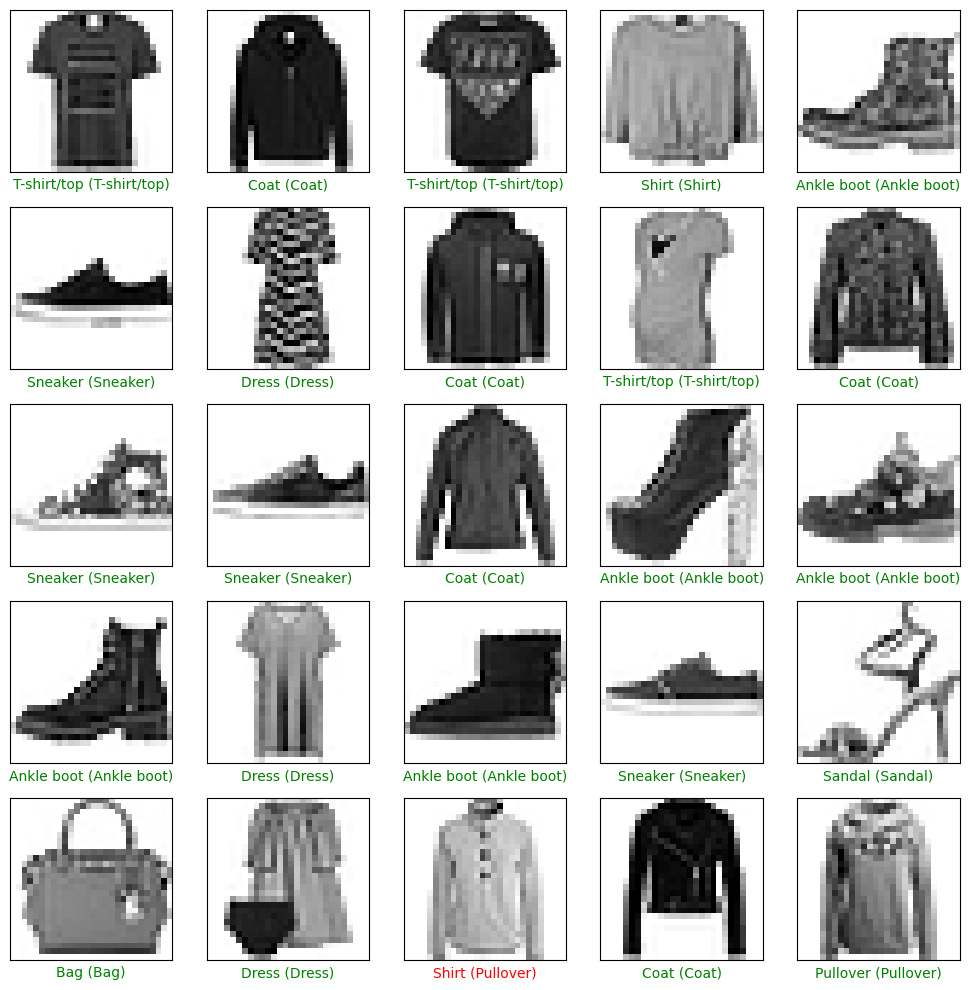

In [ ]:
#  Візуалізуємо 25 випадкових зображень і передбачення
y_pred = predictions
#  Виведення точності на тестовому наборі
test_loss, test_acc = model.evaluate(x_test_rgb, y_test_cat, verbose=0)
print(f" Тестова точність: {test_acc:.2%}")

figure = plt.figure(figsize=(10, 10))
indices = np.random.choice(len(x_test), size=25, replace=False)

for i, idx in enumerate(indices):
    ax = figure.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]), cmap=plt.cm.binary)

    pred_idx = np.argmax(y_pred[idx])
    true_idx = y_test[idx]

    ax.set_xlabel(
        f"{class_names[pred_idx]} ({class_names[true_idx]})",
        color=("green" if pred_idx == true_idx else "red"),
    )

plt.tight_layout()
plt.show()

===========================
# 7. Графік навчання
===========================

In [ ]:
# Графіки точності та втрати
plt.figure(figsize=(12, 5))

# Точність
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Точність під час навчання")
plt.xlabel("Епоха")
plt.ylabel("Точність")
plt.legend()

# Втрата
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Втрата під час навчання")
plt.xlabel("Епоха")
plt.ylabel("Втрата")
plt.legend()

plt.tight_layout()
plt.show()

# Порівняння моделей класифікації Fashion-MNIST

---

## ✅ 1. Базова CNN з нуля

**Архітектура:**
- Conv2D + MaxPooling
- Flatten → Dense → Softmax

**Результати:**
- Валідаційна точність: ~87%
- Тестова точність: ~86–87%

**Висновок:**
- Базовий рівень.
- Модель проста і стабільна, але не витягує складні зразки.
- Добре для старту, але точність обмежена.

---

## ✅ 2. VGG16 (переднавчена, заморожена)

**Архітектура:**
- VGG16 (`include_top=False`, `trainable=False`)
- GlobalAveragePooling + Dense

**Результати:**
- Валідаційна точність: ~88.5%
- Тестова точність: ~88.3%

**Висновок:**
- Якість покращилась без навчання самої VGG.
- Швидке тренування.
- Але точність стабілізувалась — далі не росте.

---

## ✅ 3. VGG16 + Fine-Tuning (розморожено останні 4 шари)

**Архітектура:**
- Ті самі шари + розморожені останні 4 шари VGG
- Learning rate: `1e-5`

**Результати:**
- Валідаційна точність: **92.3%**
- Тестова точність: **92.05%**
- Найкращі класи: `Sandal`, `Bag`, `Ankle boot`
- Слабший клас: `Shirt` (~75%)

**Висновок:**
- Найкраща модель ✅
- Fine-tuning покращив точність на ~4%
- Гарна генералізація, без переобучення

---

## 🏆 Висновок

> **Найкраща модель — VGG16 з Fine-Tuning**  
> ✔️ Найвища точність  
> ✔️ Адаптована до Fashion-MNIST  
> ✔️ Стабільна і точна


In [ ]:
model.save("vgg16_finetuned.keras")